# Economics of Cyber Security

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

### The data

The data is collected from: https://spoofer.caida.org/as_stats.php for the time period of April 2020 to September 2020.

## Recent test

### Cleaning

In [117]:
test_df = pd.read_csv("recent_tests.csv", sep=';', dtype={'Sesssion': 'str'})

#Resetting types
test_df.astype({'Timestamp': 'str',
                'Client IP Block': 'str',
                'ASN': 'str', 
                'Country': 'str', 
                'NAT': 'str', 
                'Outbound Private Status': 'str',
               'Adjacent Spoof Prefix Length': 'str'}).dtypes

df_blocked = test_df.loc[test_df['Outbound Routable Status'] == 'blocked']
df_received = test_df.loc[test_df['Outbound Routable Status'] == 'received']

c:\users\seven\pycharmprojects\econ_sec\venv\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Statical functions

In [118]:
def table_states(curr_df):
    
    print("Total number of rows in table: %s" %curr_df.shape[0])

    print("Number of unique counties:  %s" %curr_df['Country'].nunique())
    print("Number of unique ASN:  %s" %curr_df['ASN'].nunique())
    
    NAT = curr_df.loc[curr_df['NAT'] == 'yes']
    NAT_percentage = round((NAT.shape[0] / curr_df.shape[0]) * 100.0, 2)
    print("Percentage using NAT: %s%%" %NAT_percentage)

### Visuals helper function

In [119]:
#Helper to number of neg and pos NAT for all cases
def NAT_count(df, val):
    NAT_temp = df.loc[df['NAT'] == val]
    
    return NAT_temp.shape[0]

#Bar chart for the chosen column with a certain threshold of minimum count. 
#Option of including or excluding NAT
def plot_stats(df, column, title, threshold, NAT = False):
    fig = plt.figure(figsize=(22, 8))
    ax = fig.add_axes([0,0,1,1])
    
    columns = df[column].unique()
    counts = []
    included = []
    excluded = []
        
    if not NAT:
        for col in columns:
            temp_df = df.loc[df[column] == col]
            
            if temp_df.shape[0] > threshold:
                counts.append(temp_df.shape[0])
                included.append(col)
            else:
                excluded.append(col)
            
        ax.bar(columns, counts)
    
    else:
        NAT_pos_count = []
        NAT_neg_count = []
        
        for col in columns:
            temp_df = df.loc[df[column] == col]
            
            if temp_df.shape[0] > threshold:
                NAT_pos_count.append(NAT_count(temp_df, 'yes'))
                NAT_neg_count.append(NAT_count(temp_df, 'no'))
                included.append(col)
            else:
                excluded.append(col)
            
        ax.bar(included, NAT_pos_count)
        ax.bar(included, NAT_neg_count)
        ax.legend(labels=['NAT present', 'NAT not present'])
        
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(title)
    plt.xticks(rotation=90)
    plt.show()
    
    if len(excluded) > 0:
        print("Number of excluded cases using threshold of %s: %s" % (threshold, len(excluded)))
    else:
        print("All values are depicted")

### Complete set analysis

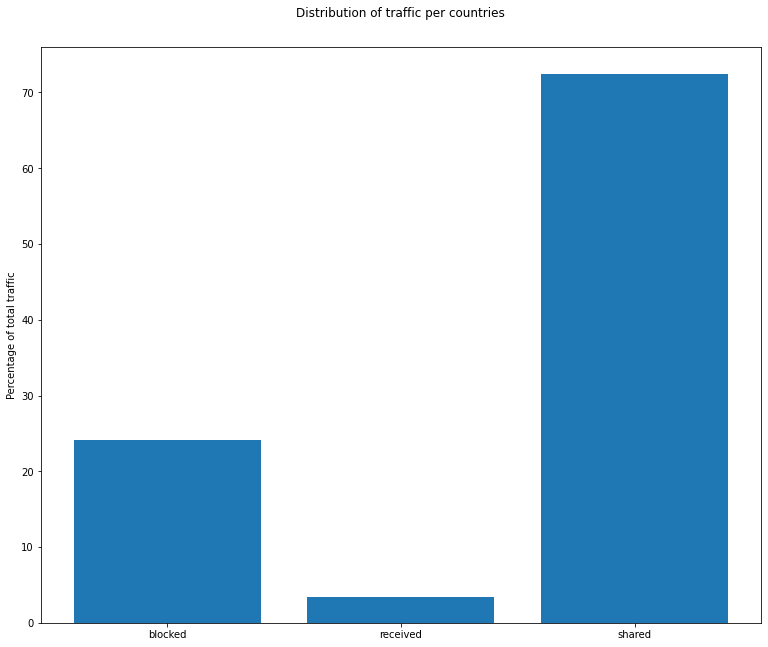

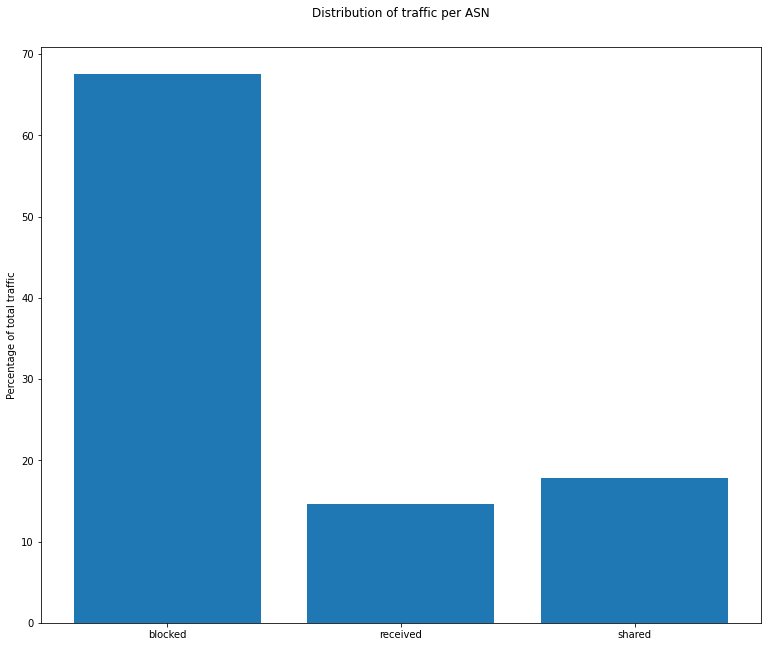

In [120]:
#Bar chart to analyse the unique cases compared to the shared one with both received and blocked cases
def check_cases(df_block, df_receive, column, title):
    unique_blocked = df_block[column].unique()
    unique_received = df_received[column].unique()
    
    shared = [x for x in unique_blocked if x in unique_received]
    blocked = [x for x in unique_blocked if x not in shared]
    received = [x for x in unique_received if x not in shared]
    
    labels = ['blocked', 'received', 'shared']
    total = len(shared) + len(blocked) + len(received)
    
    percentage = [round((len(blocked)/total)*100, 2), round((len(received)/total)*100, 2), round((len(shared)/total)*100, 2)]
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_axes([0,0,1,1])
    
    ax.bar(labels, percentage)
    ax.set_title(title, pad = 30)
    ax.set_ylabel("Percentage of total traffic")
    
    plt.show()

check_cases(df_blocked, df_received, "Country", "Distribution of traffic per countries")
check_cases(df_blocked, df_received, "ASN", "Distribution of traffic per ASN")

Three kinds of cases for categorizing the data. Blocked is cases when the ASes check the IP address before delivering packets outside of their network. Received cases are when an AS receives packets which are spoofed, which is out of their control, since they do not control the traffic that they are sent. Shared is the ASN or Country which show cases of both received and blocked traffic. This is particularly interesting with regard to the ASN 

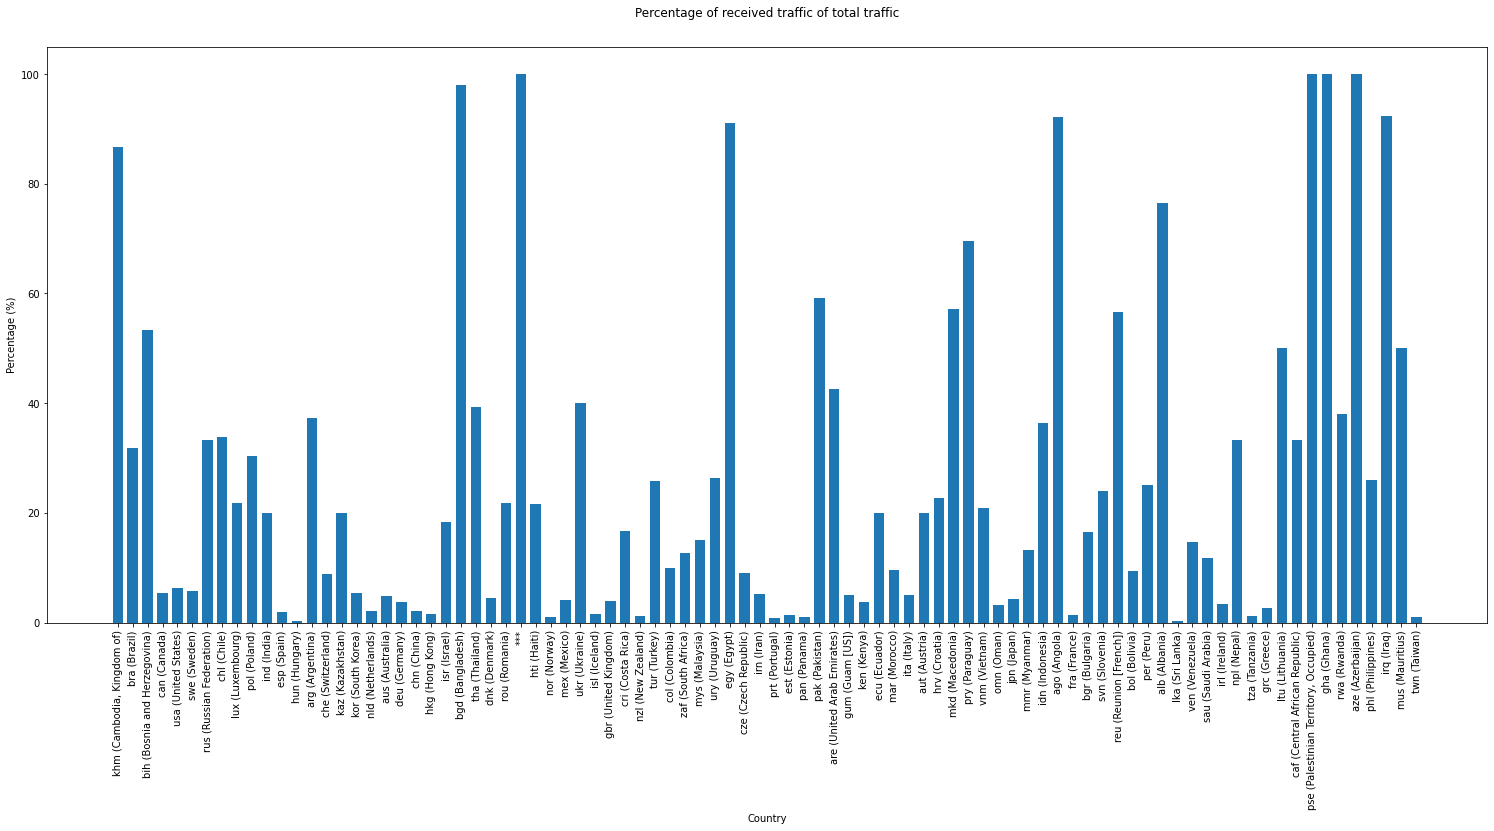

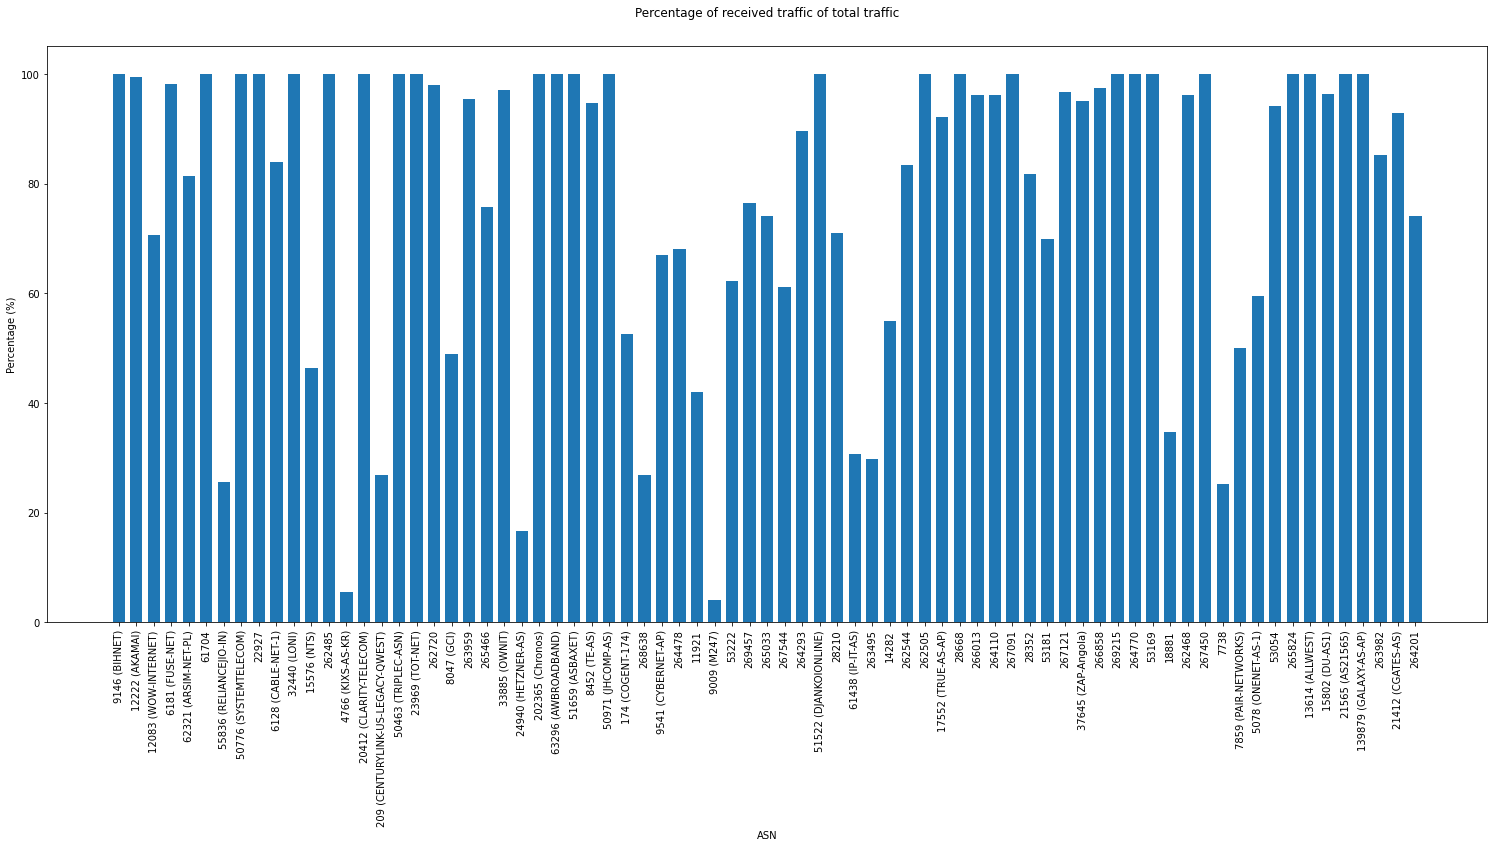

In [121]:
def column_percentage(df1, df2, column, title, threshold=0):
    blocked_countries = df1[column].unique().tolist()
    received_countries = df2[column].unique().tolist()
    
    country_list = []
    percentages = []
    
    for val in received_countries:
        received_country_df = df2.loc[df2[column] == val]
        if val in blocked_countries:
            blocked_country_df = df1.loc[df1[column] == val]
            
            if received_country_df.shape[0] > threshold:
                percentage = round((received_country_df.shape[0]/(blocked_country_df.shape[0] + received_country_df.shape[0])) *100, 2)
                percentages.append(percentage)
                
                country_list.append(val)
            
        else:
            if received_country_df.shape[0] > threshold:
                percentages.append(100)
                country_list.append(val)
                
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(country_list, percentages, width=0.7)
    
    ax.set_title(title, pad = 30)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel(column)
    
    plt.xticks(rotation=90)
    plt.show()
               
column_percentage(df_blocked, df_received, 'Country', "Percentage of received traffic of total traffic")
column_percentage(df_blocked, df_received, 'ASN', "Percentage of received traffic of total traffic", 20)

In this graph we have an overview of the received packages against the total of blocked and complete packages

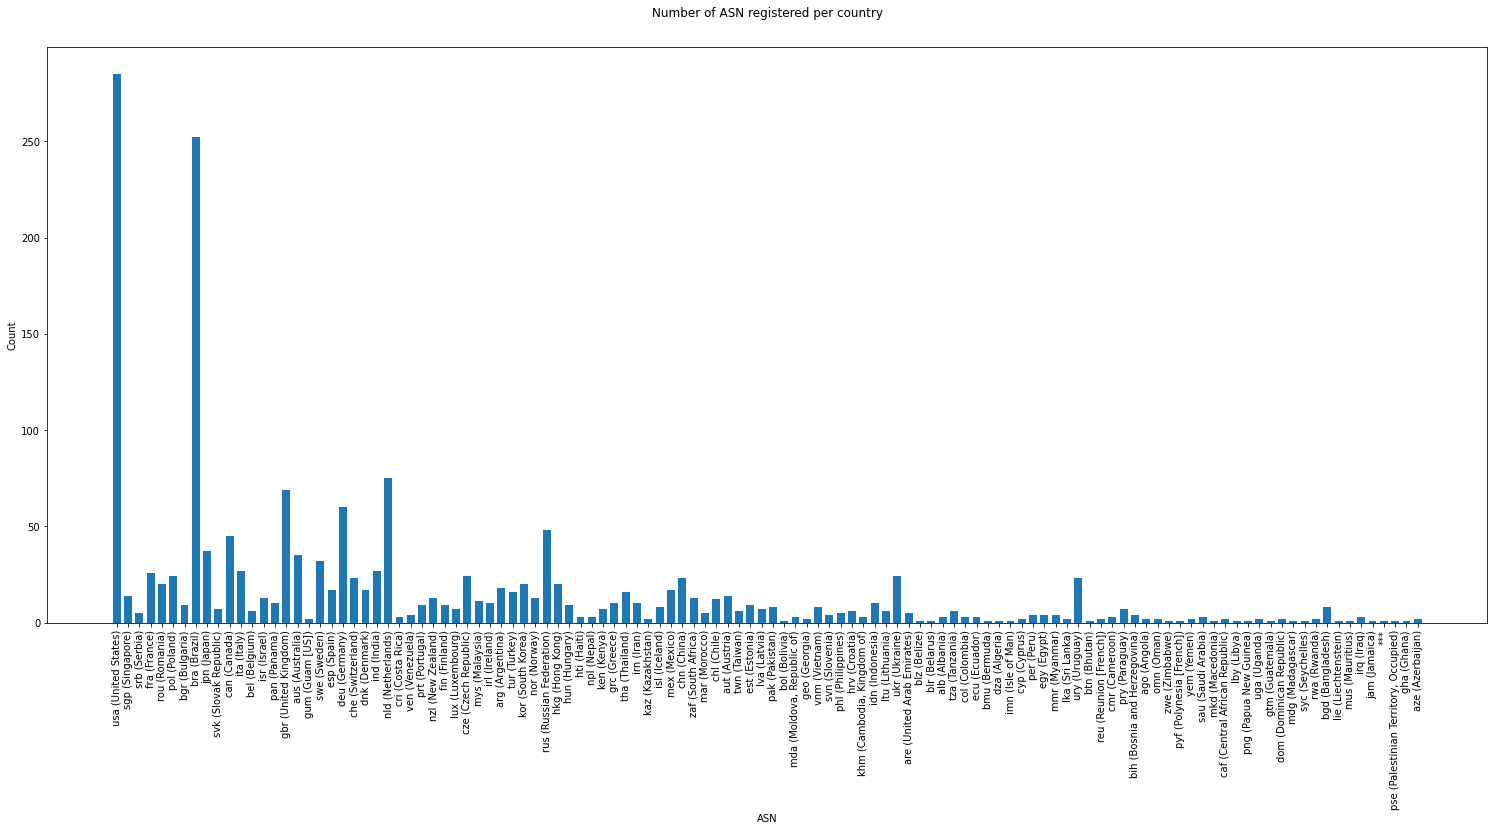

In [122]:
def asn_country_count(df, columnSplit, columnCount, title):
    countries = df[columnSplit].unique()
    
    counts = []
    for country in countries:
        country_df = df.loc[df[columnSplit] == country]
        counts.append(country_df[columnCount].nunique())
    
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(countries, counts, width=0.7)
    
    ax.set_title(title, pad = 30)
    ax.set_ylabel("Count")
    ax.set_xlabel(columnCount)
    
    plt.xticks(rotation=90)
    plt.show()

joined_df = df_blocked.append(df_received)
asn_country_count(joined_df, "Country", "ASN", "Number of ASN registered per country")
        
    

The number of ASN per country in the Spoofer database

### Blocked information

In [123]:
table_states(df_blocked)

Total number of rows in table: 38539
Number of unique counties:  112
Number of unique ASN:  1251
Percentage using NAT: 61.43%


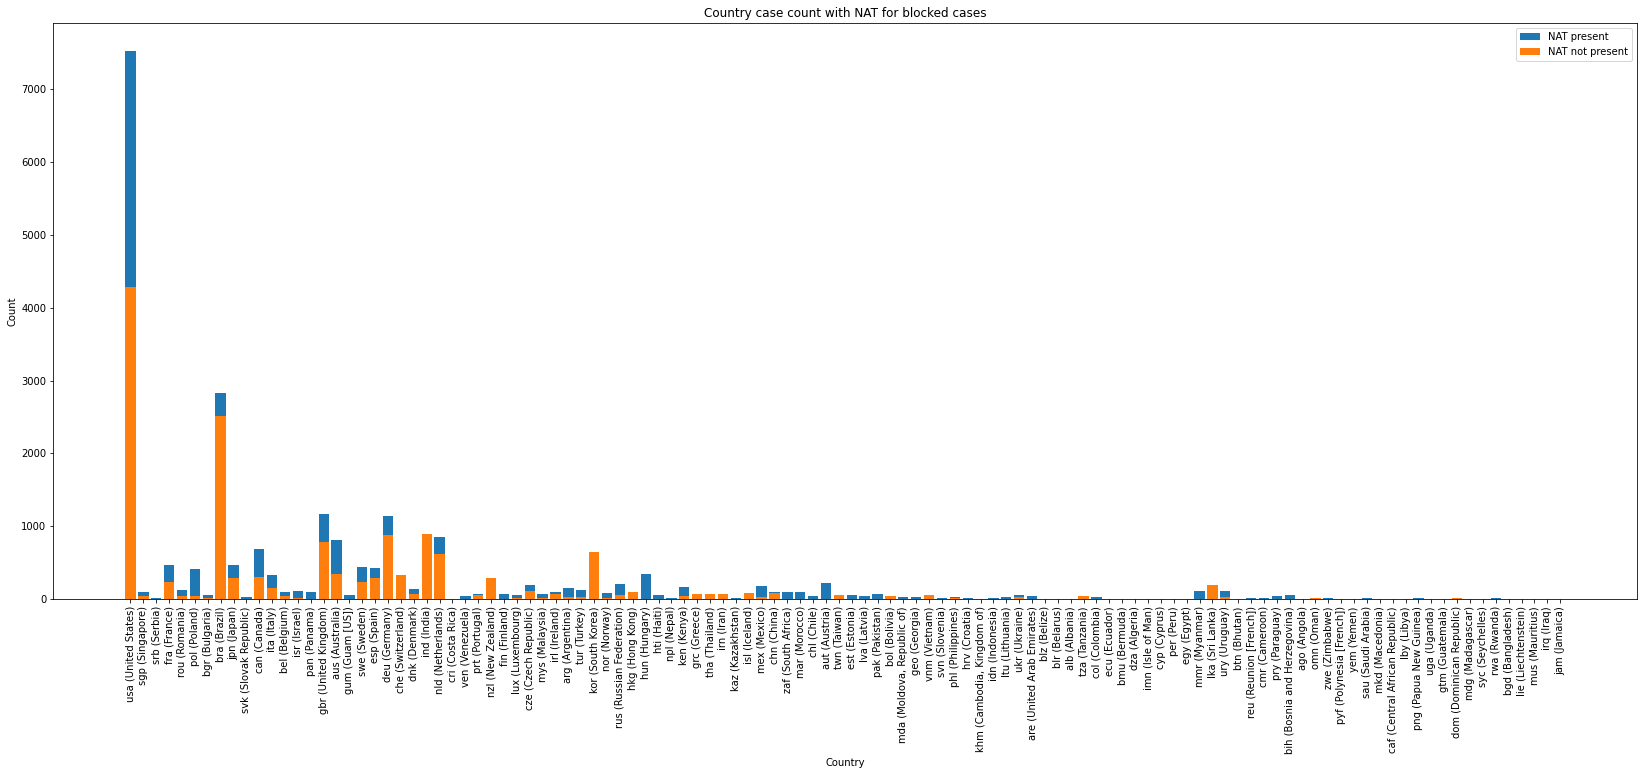

All values are depicted


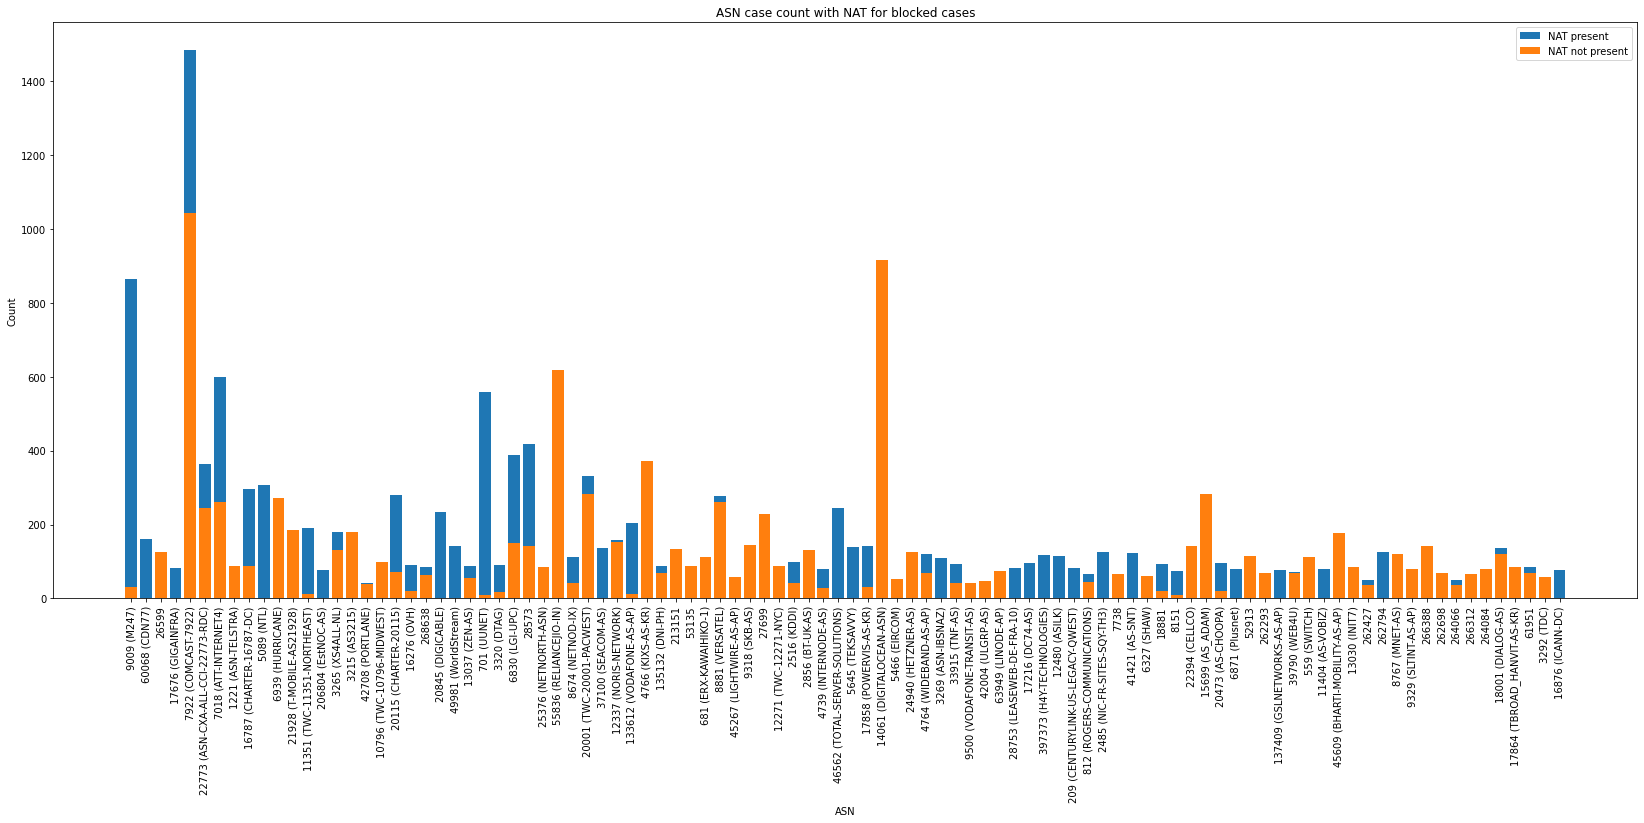

Number of excluded cases using threshold of 75: 1153


In [124]:
plot_stats(df_blocked, "Country", 'Country case count with NAT for blocked cases', 0, True)
plot_stats(df_blocked, "ASN", 'ASN case count with NAT for blocked cases', 75, True)

### Received information

In [125]:
table_states(df_received)

Total number of rows in table: 5838
Number of unique counties:  88
Number of unique ASN:  476
Percentage using NAT: 59.82%


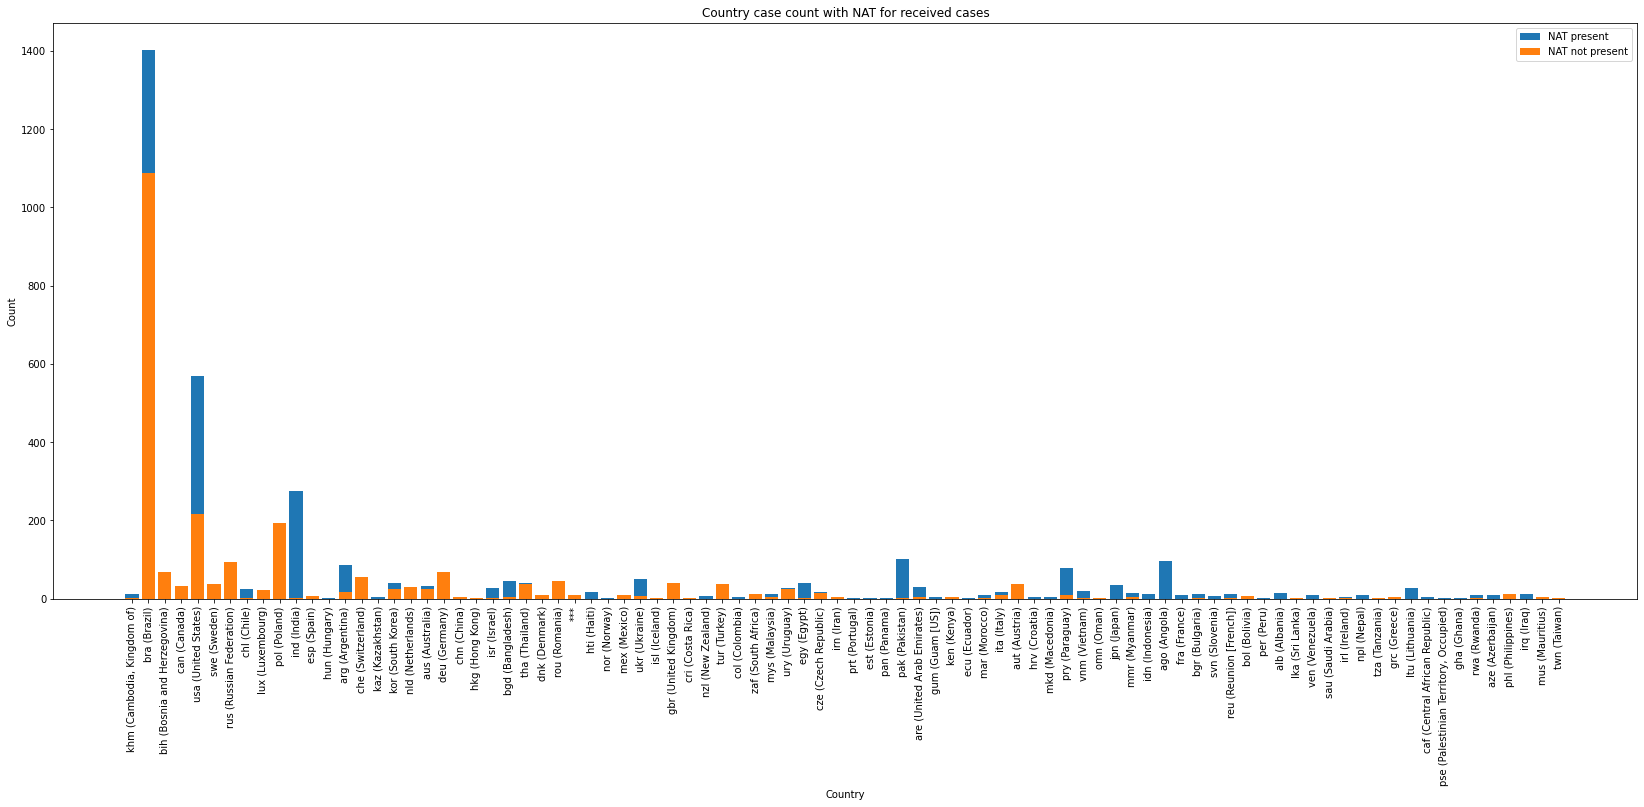

All values are depicted


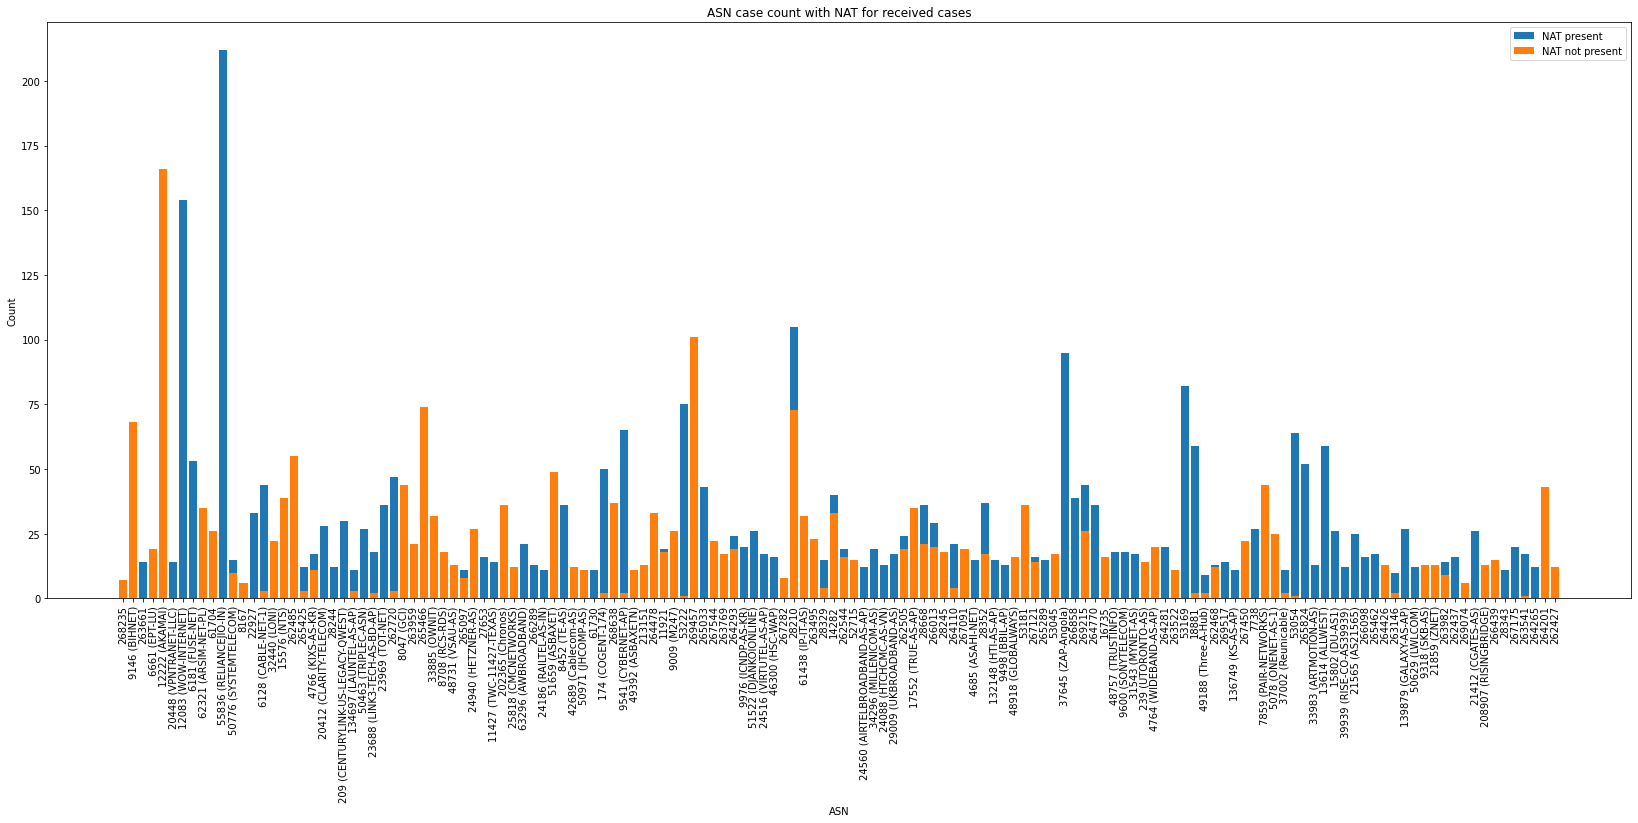

Number of excluded cases using threshold of 10: 332


In [126]:
plot_stats(df_received, "Country", 'Country case count with NAT for received cases', 0, True)
plot_stats(df_received, "ASN", 'ASN case count with NAT for received cases', 10, True)

### REMEDIES 

In [193]:
test_df = pd.read_csv("remedies.csv", sep=';')


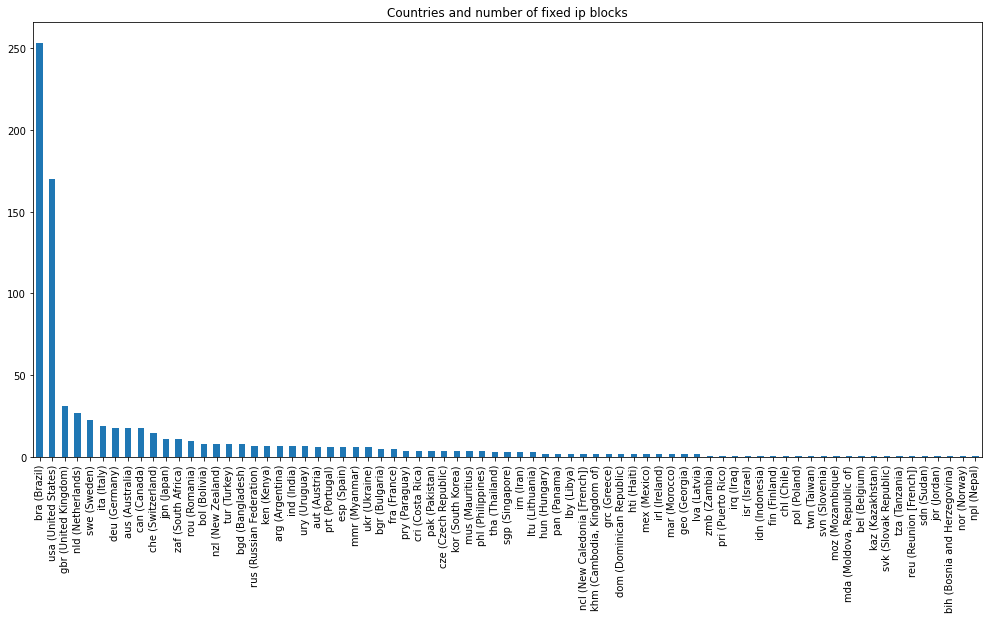

In [128]:
fig, ax = plt.subplots(figsize=(17,8))
ax.set_title('Countries and number of fixed ip blocks')
test_df['Country'].value_counts().plot(ax=ax, kind='bar')
plt.show()

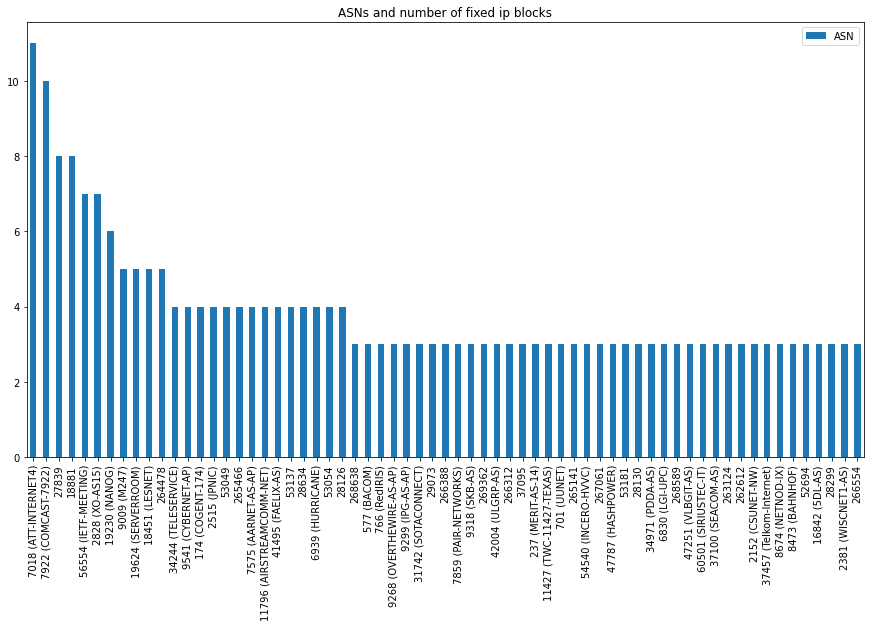

In [129]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('ASNs and number of fixed ip blocks')
y = pd.DataFrame(test_df['ASN'].value_counts())
y = y[y['ASN'] > 2]
y.plot(ax=ax, kind='bar')
plt.show()



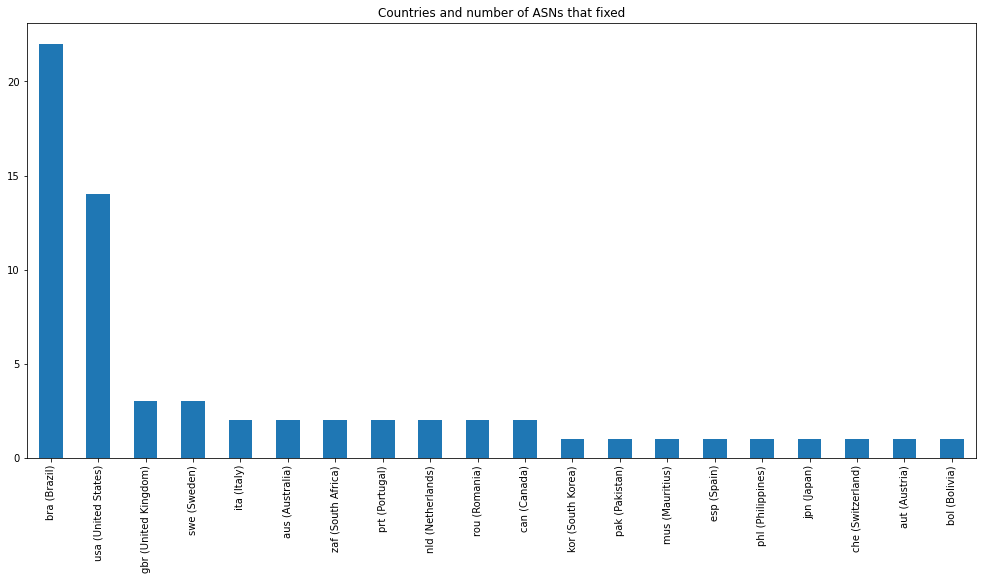

In [130]:
y = pd.DataFrame(test_df['ASN'].value_counts())
y = y[y['ASN'] > 2]
y = y.reset_index()
y.columns = ['ASN', 'count']
countries = y.ASN.replace(test_df.set_index('ASN')['Country'])
y['Country'] = countries
fig, ax = plt.subplots(figsize=(17,8))
ax.set_title('Countries and number of ASNs that fixed')
y['Country'].value_counts().plot(ax=ax, kind='bar')
plt.show()

In [189]:
test_df = pd.read_csv("remedies.csv", sep=';')

# compare ASN level stats on spoofable IP blocks before and after remedies - 

In [206]:
spoofable_df = df_received.groupby('ASN')
spoofable_df = spoofable_df.count()[['Client IP Block']]
spoofable_df = spoofable_df.rename(columns={"Client IP Block" : "Spoofable Blocks"})


In [207]:
unspoofable_df = df_blocked.groupby('ASN')
unspoofable_df = unspoofable_df.count()[['Client IP Block']]
unspoofable_df = unspoofable_df.rename(columns={"Client IP Block" : "Unspoofable Blocks"})


In [208]:
remedies_df = test_df.groupby('ASN')
remedies_df = remedies_df.count()[['IP Block']]
remedies_df = remedies_df.rename(columns={"IP Block" : "Blocks Fixed"})


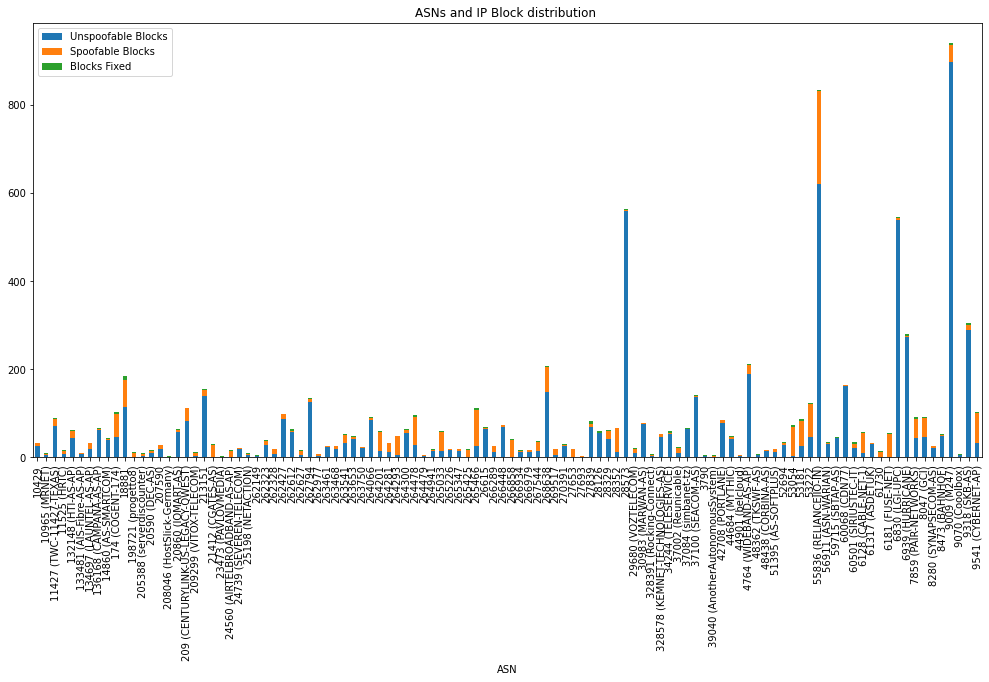

In [209]:
final_df = unspoofable_df.merge(spoofable_df, on="ASN").merge(remedies_df, on="ASN")
final_df = final_df.rename(columns={"IP Block": "Fixed Blocks"})
final_df.plot(kind='bar', stacked=True,figsize=(17,8), title="ASNs and IP Block distribution ")
plt.show()

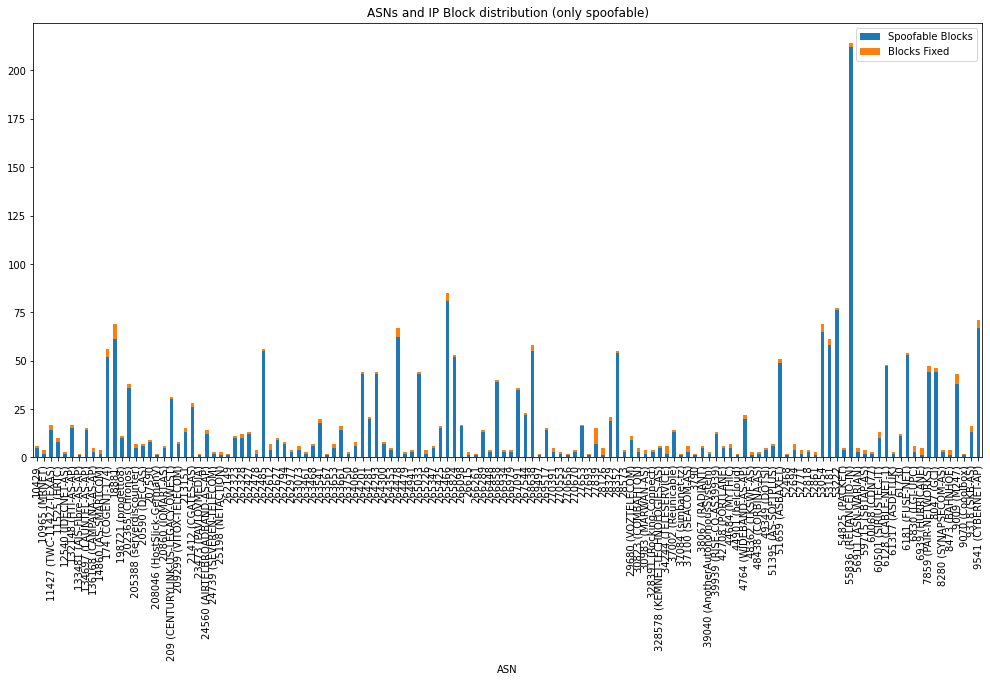

In [210]:
final_df = spoofable_df.merge(remedies_df, on="ASN")
final_df = final_df.rename(columns={"IP Block": "Fixed Blocks"})
final_df.plot(kind='bar', stacked=True,figsize=(17,8),  title="ASNs and IP Block distribution (only spoofable)")
plt.show()

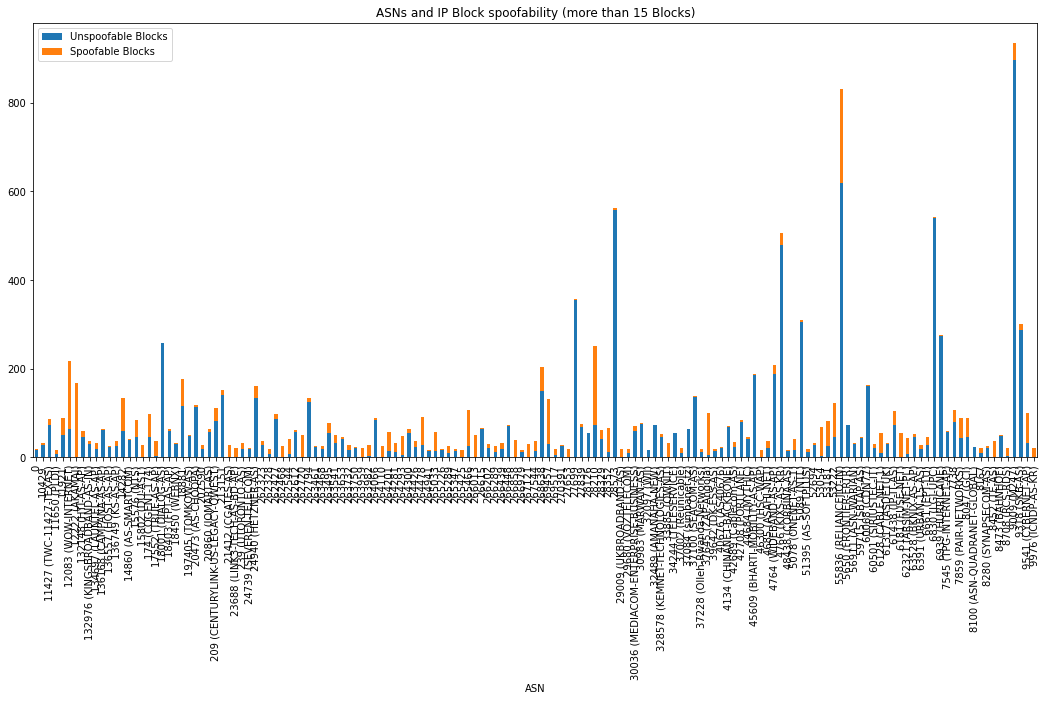

In [211]:
final_df = unspoofable_df.merge(spoofable_df, on="ASN")
final_df = final_df[final_df['Unspoofable Blocks'] + final_df['Spoofable Blocks'] > 15]
final_df.plot(kind='bar', stacked=True,figsize=(18,8),  title="ASNs and IP Block spoofability (more than 15 Blocks)")
plt.show()